In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering 

#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
data=pd.read_excel('Credit Card Customer Data.xlsx', sheet_name='Sheet1')

In [3]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
df = data.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [6]:
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

In [7]:
df['Customer Key'].duplicated().sum()

5

In [8]:
duplicateRowsDF = df[df['Customer Key'].duplicated(keep=False)]
duplicateRowsDF

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
48,49,37252,6000,4,0,2,8
104,105,97935,17000,2,1,2,10
332,333,47437,17000,7,3,1,0
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
411,412,50706,44000,4,5,0,2
432,433,37252,59000,6,2,1,2
541,542,50706,60000,7,5,2,2
632,633,97935,187000,7,1,7,0


**Observations**

1. The Dataset has 660 Rows and 7 Columns/attributes which are all integers.
2. There are non null values in any of the attributes/variables
3. We found that there are 5 duplicate values in the "Customer Key" feature but upon further investigation we see that all the other features of the respective rows are different. So we will not drop these duplicates.


In [9]:
df.describe()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


**Observation**

1. Average credit limit is 34878. Data seems to be right skewed.
2. Average of Total credit card is 4.7 which is approx equal to median value of 5. Same observation for other three columns.

In [10]:
df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

**No missing values in data set**

### Univariate Analysis 

In [11]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical
# variable.
# This function takes the numerical column as the input and returns the boxplots
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.distplot(
        feature, kde=False, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram

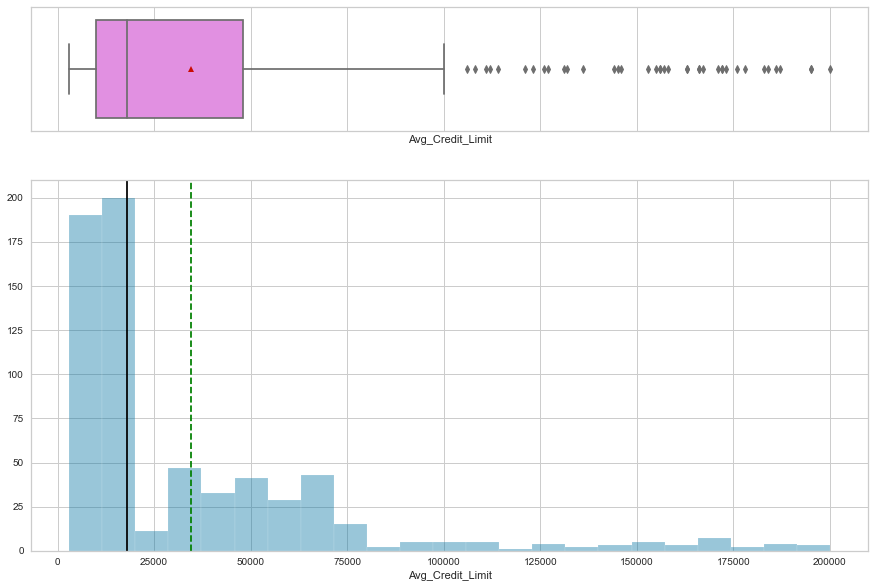

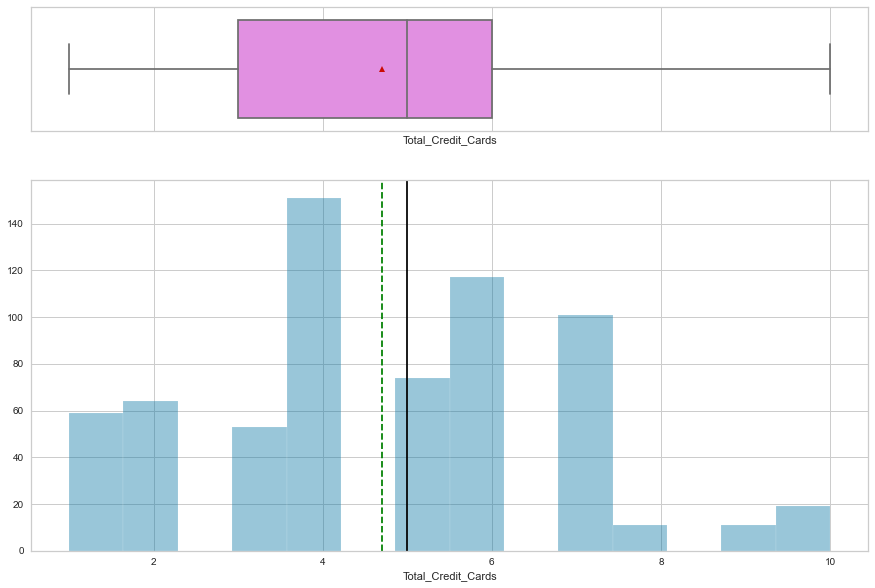

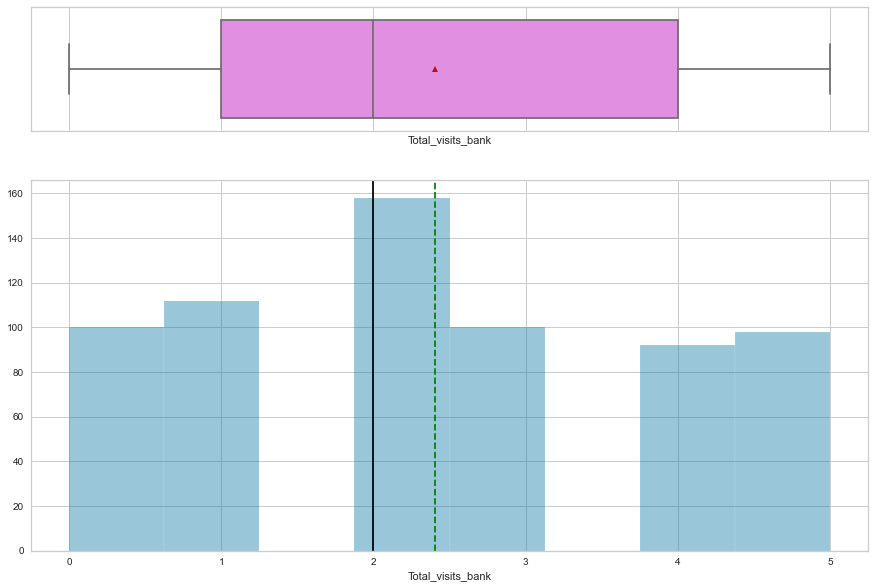

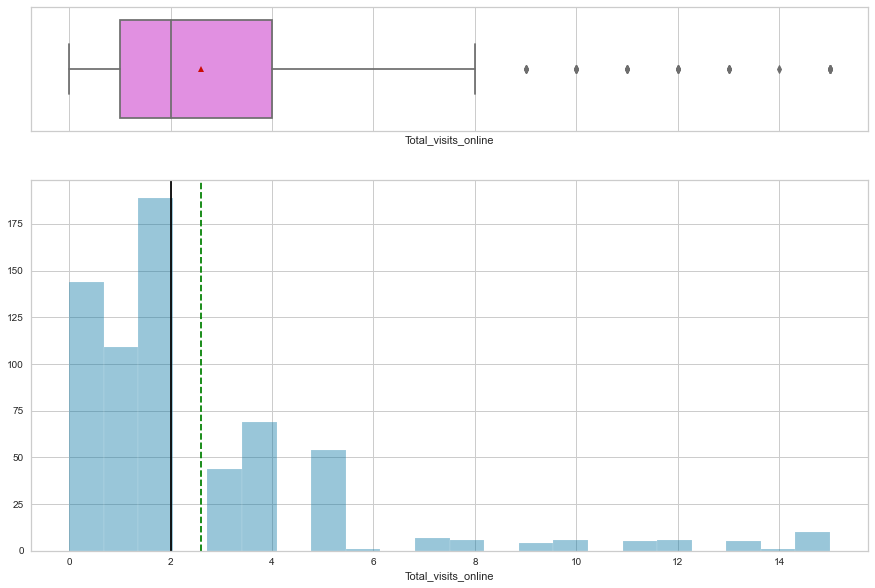

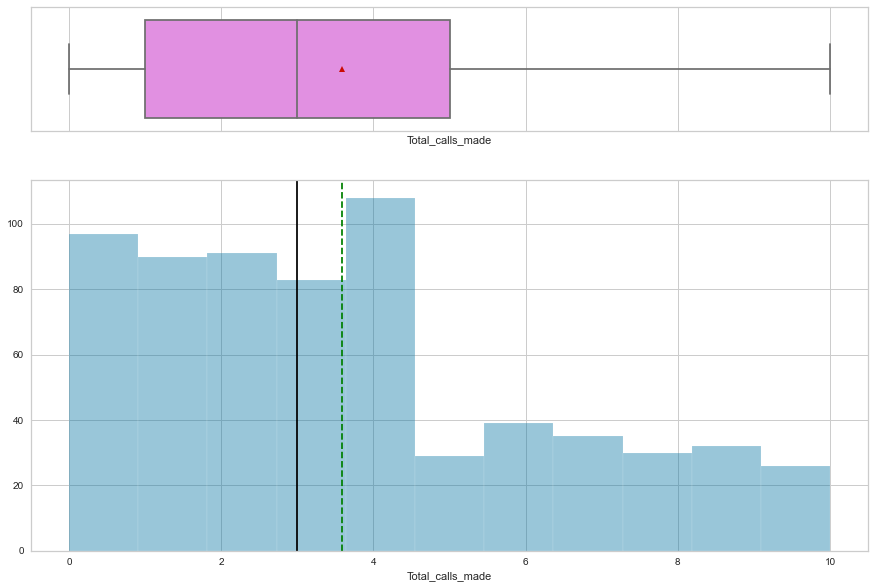

In [12]:
all_col = ['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']
for col in all_col:
    histogram_boxplot(data[col])

**Observation**
1. Avg_Credit_Limit data is right skewed. We also see few outliers.
2. The mean and median value for Total_Credit_Cards is approx same as we found earlier as well.
3. Total_visits_online data is right skewed.
4. There is no need for treatment for the outliers. The aim is to define clusters within dataset.

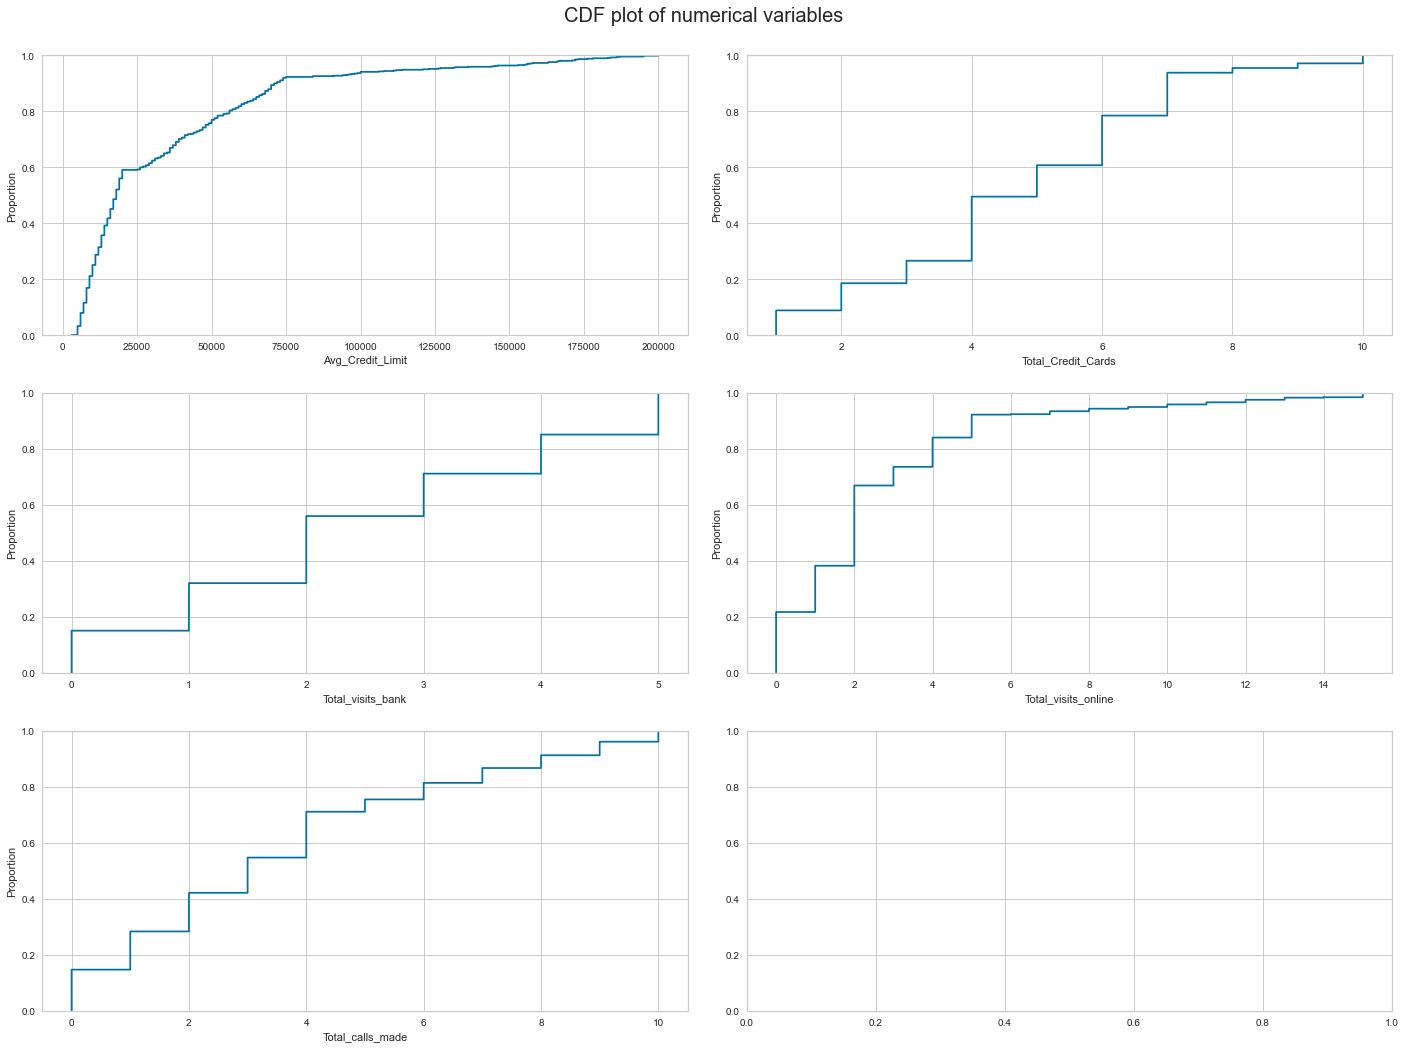

In [13]:
fig, axes = plt.subplots(3, 2,  figsize=(20, 15))
fig.suptitle('CDF plot of numerical variables', fontsize=20)
counter = 0
for i in range(3):
    sns.ecdfplot(ax=axes[i][0],x=df[all_col[counter]])
    counter = counter+1
    if counter != 5:
        sns.ecdfplot(ax=axes[i][1],x=df[all_col[counter]])
        counter = counter+1
    else:
        pass


fig.tight_layout(pad=2.0)

**Observations**
1. 95 % of the customers have credit limit less than 75000.
2. 92% of the customers make total online visits less than 5 
3. 96% of the customers have less than 7 credit cards.

### KDE plot for all the features to see how many of it can show separate clusters. 

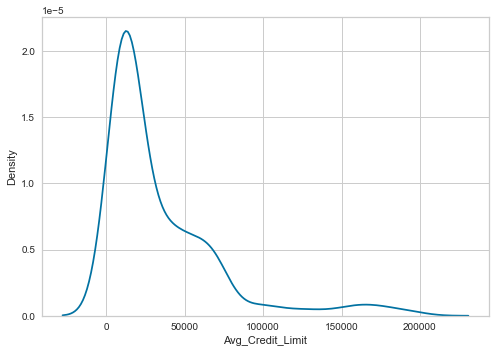

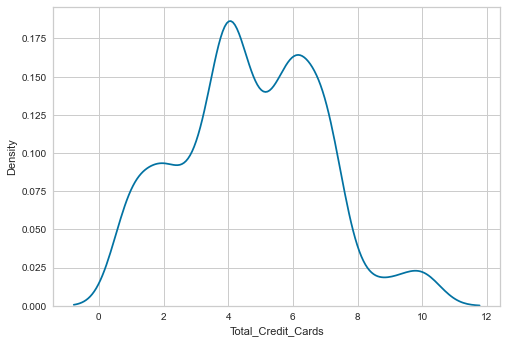

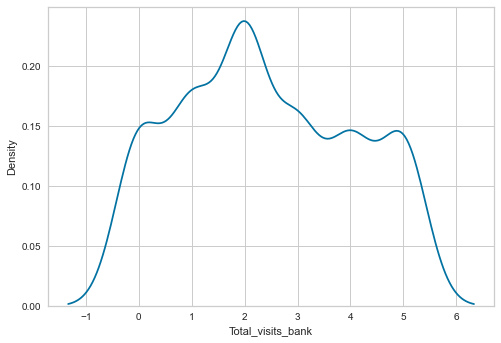

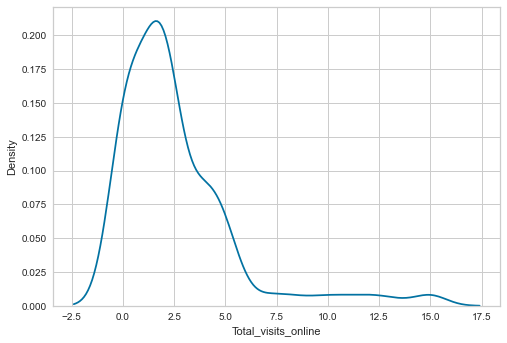

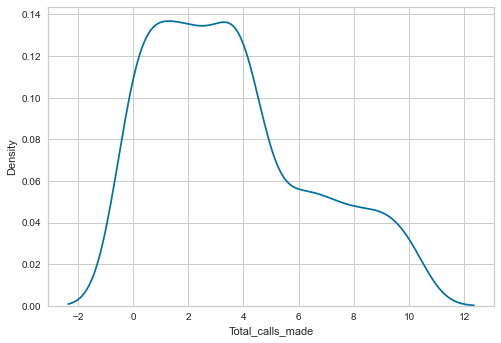

In [14]:
for col in all_col:
    sns.distplot(df[col],hist=False,)
    plt.show()

### Bivariate Analysis 

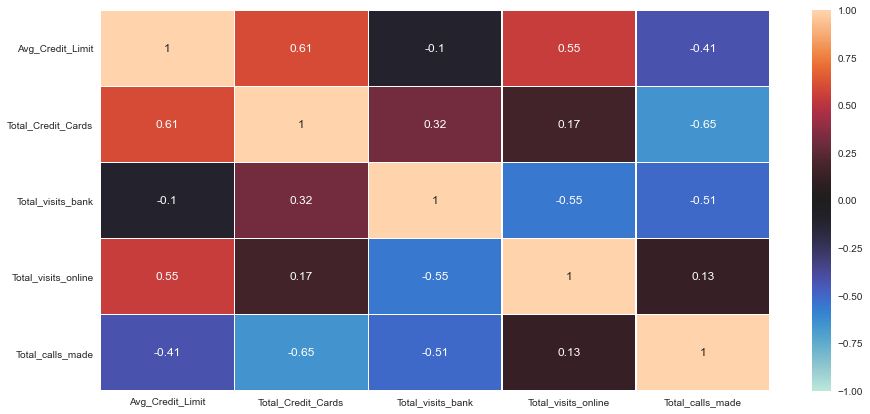

In [15]:
plt.figure(figsize=(15,7))

sns.heatmap(df[all_col].corr(),
            annot=True,
            linewidths=0.5,vmin=-1,vmax=1,
            center=0,
            cbar=True,)            

plt.show()

**Observation**
1. The highest corealtion is between Avg_Credit_limit and Total_Credit_Cards, which seems to be logical.
2. The least corealtion is between Total_Credit_Cards and Total_calls_made.
3. Total_visits_bank and negative corelation with Total_visits_online and Total_calls_made. This indicates that the csutomers who vists online or make phone calls to bank tends to not visit bank physically.

### Prepare the dataset for clustering 

In [16]:
#Creating two copies of data for two different clustering
df_KMeans = data.copy()
df_HC = data.copy()

In [17]:
# variables used for clustering
all_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

In [18]:
# Scaling the dataset before clustering
scaler=StandardScaler()
subset=df[all_col].copy()
subset_scaled = scaler.fit_transform(subset)  

In [19]:
subset_scaled_df_for_KMeans = pd.DataFrame(subset_scaled,columns=subset.columns)
subset_scaled_df_for_HC = pd.DataFrame(subset_scaled,columns=subset.columns)

### K-Means Clustering 

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9429789712808515
Number of Clusters: 7 	Average Distortion: 0.9095950026993534
Number of Clusters: 8 	Average Distortion: 0.89729442535762


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

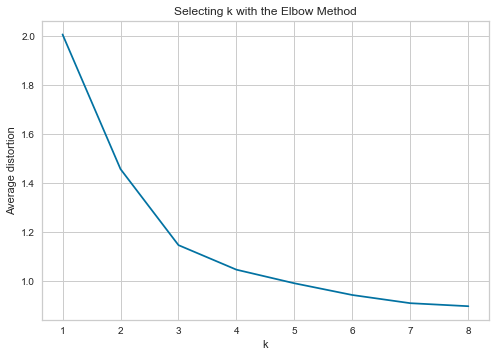

In [20]:
clusters=range(1,9)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(subset_scaled_df_for_KMeans)
    prediction=model.predict(subset_scaled_df_for_KMeans)
    distortion=sum(np.min(cdist(subset_scaled_df_for_KMeans, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df_for_KMeans.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

**Appropriate k seems to be 3 or 4.**


For n_clusters = 2, silhouette score is 0.41842496663230405)
For n_clusters = 3, silhouette score is 0.5157182558882754)
For n_clusters = 4, silhouette score is 0.35566706193773706)
For n_clusters = 5, silhouette score is 0.27239112356985445)
For n_clusters = 6, silhouette score is 0.25545029453735185)
For n_clusters = 7, silhouette score is 0.24914218332438615)
For n_clusters = 8, silhouette score is 0.2262940818988599)


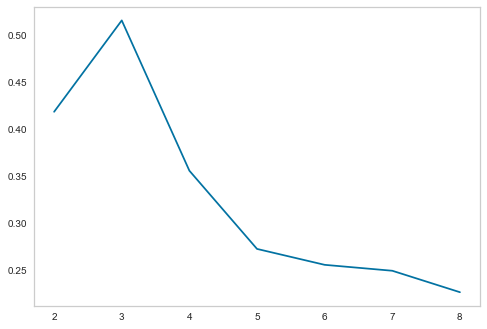

In [21]:
#Lets calculate silhouette score.
sil_score = []
cluster_list = list(range(2,9))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df_for_KMeans))
    score = silhouette_score(subset_scaled_df_for_KMeans, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list,sil_score)
plt.grid()

**Silhouette score for 3 is high, so we will choose 3 as value of k.**

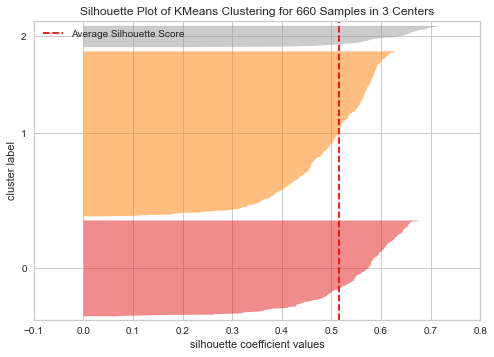

In [22]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(subset_scaled_df_for_KMeans)    
visualizer.show();

#### Lets plot the numerical variables for each cluster 

In [29]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df_for_KMeans)
df_KMeans['K_means_clusters'] = kmeans.labels_
subset_scaled_df_for_KMeans['K_means_clusters'] = kmeans.labels_

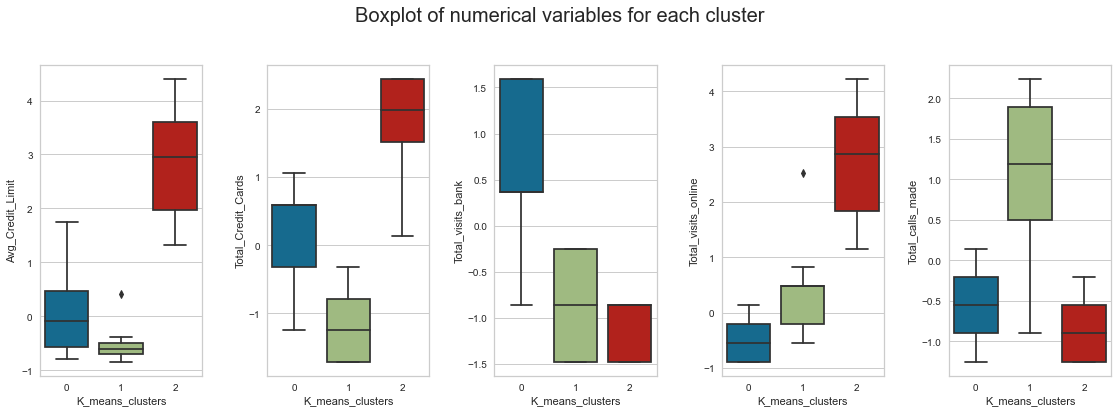

In [31]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for i in range(5):
    sns.boxplot(ax=axes[i],y=subset_scaled_df_for_KMeans[all_col[counter]],x=subset_scaled_df_for_KMeans['K_means_clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

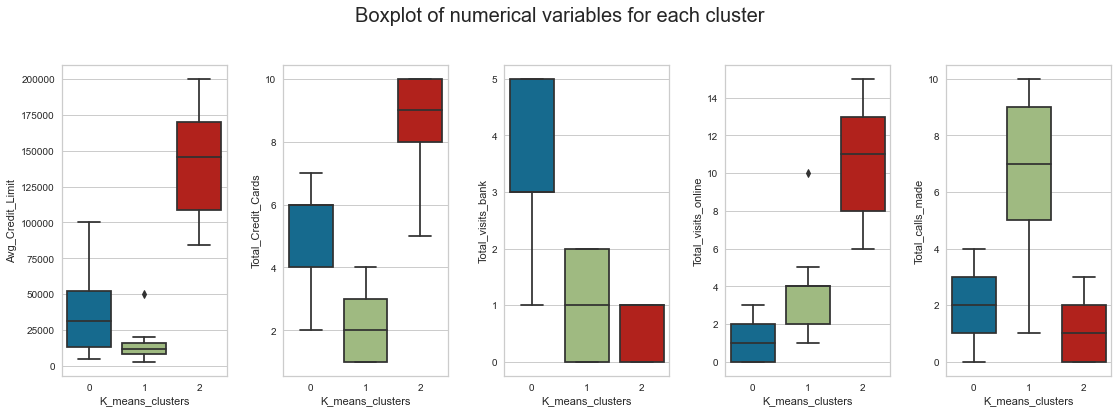

In [35]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df_KMeans[all_col[counter]],x=subset_scaled_df_for_KMeans['K_means_clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

**Observation**

1. Average credit limit for cluster0 customers is around 32000. Cluster1 customers have least averae credit limit.
2. Cluster 1 customers hold least amount of credit card with mean around 2.
3. Cluster 0 customer make most of the bank visits.
4. Cluster2 customers make most online visits.
5. Cluster1 customer makes most phone calls

### Hierarchical Clustering

In [36]:
# Lets find out the cophenet index.
# closer it is to 1, the better is the clustering
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
linkage_methods = ['single', 'complete', 'average','weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df_for_HC, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(subset_scaled_df_for_HC))
        print('Cophent correlation for distance metrics {} and linkage method {} is {}'.format(dm,lm,c))
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophent correlation for distance metrics euclidean and linkage method single is 0.7391220243806552
Cophent correlation for distance metrics euclidean and linkage method complete is 0.8599730607972423
Cophent correlation for distance metrics euclidean and linkage method average is 0.8977080867389372
Cophent correlation for distance metrics euclidean and linkage method weighted is 0.8861746814895477
Cophent correlation for distance metrics chebyshev and linkage method single is 0.7382354769296767
Cophent correlation for distance metrics chebyshev and linkage method complete is 0.8533474836336782
Cophent correlation for distance metrics chebyshev and linkage method average is 0.8974159511838106
Cophent correlation for distance metrics chebyshev and linkage method weighted is 0.8913624010768603
Cophent correlation for distance metrics mahalanobis and linkage method single is 0.7058064784553605
Cophent correlation for distance metrics mahalanobis and linkage method complete is 0.66635344638

In [37]:
print('Highest cophenet correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))

Highest cophenet correlation is 0.8977080867389372, which is obtinaed with euclidean distance metric and average linkage method


### Lets explore 'centroid', 'median','ward' linkage method which requires only Euclidean distance metrics 

In [38]:
linkage_methods = ['single', 'complete', 'average','median','ward', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df_for_HC, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(subset_scaled_df_for_HC))
    print('Cophent correlation for distance metrics {} and linkage method {} is {}'.format('euclidean',lm,c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = lm
print('*'*110)
print('Highest cophenet correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,'euclidean',high_dm_lm[0]))

Cophent correlation for distance metrics euclidean and linkage method single is 0.7391220243806552
Cophent correlation for distance metrics euclidean and linkage method complete is 0.8599730607972423
Cophent correlation for distance metrics euclidean and linkage method average is 0.8977080867389372
Cophent correlation for distance metrics euclidean and linkage method median is 0.8893799537016724
Cophent correlation for distance metrics euclidean and linkage method ward is 0.7415156284827493
Cophent correlation for distance metrics euclidean and linkage method weighted is 0.8861746814895477
**************************************************************************************************************
Highest cophenet correlation is 0.8977080867389372, which is obtinaed with euclidean distance metric and average linkage method


 **Observations**
1. we see that cophenet index is maximum with euclidean distance metric and average linkage method.
2. We also got high Cophent correlation for euclidean and cityblock distance metrics with complete and weighted linkage method.

### Lets see the dendrogram of different linkage method

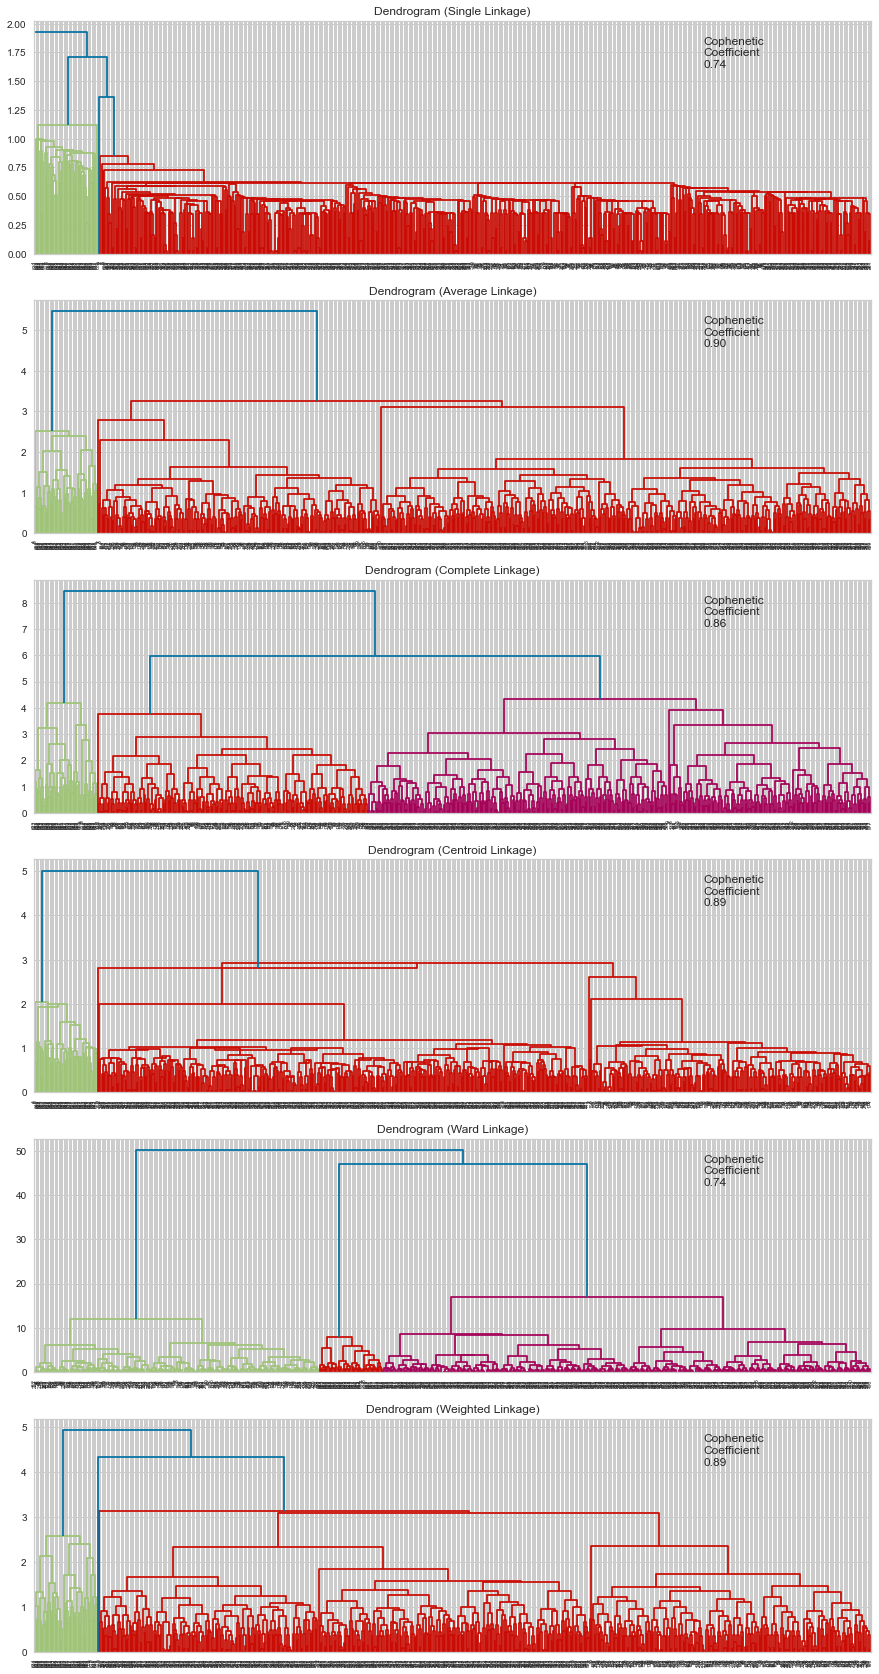

In [39]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward',
          'weighted']

# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_scaled_df_for_HC, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df_for_HC))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
    compare.append([method, coph_corr])

In [41]:
distance_metrics = [ 'euclidean','cityblock']
linkage_methods = ['complete', 'weighted']

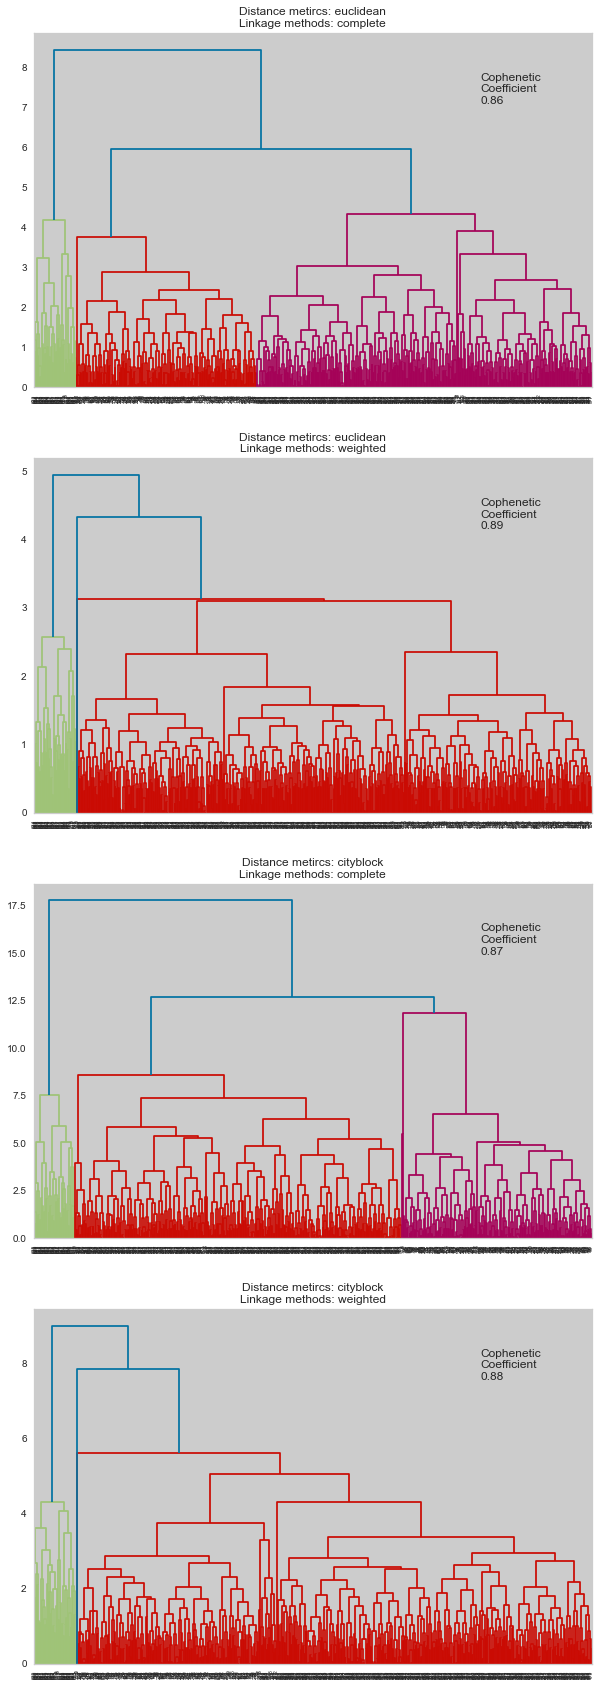

In [42]:
# Create a subplot image
fig, axs = plt.subplots(len(distance_metrics)+len(distance_metrics), 1, figsize=(10, 30))
i=0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df_for_HC, metric=dm, method=lm)
        dendrogram(Z,  ax=axs[i]);
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))
        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df_for_HC))
        axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                        (0.80, 0.80),
                        xycoords='axes fraction')
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))                        
        i +=1

**Observation**
1. Out of all dendograms we see above, it is clear that ward linkage method gave us separate and distinct clusters.
2. Looking at that dendogram, lets try to crete 3 clusters which seems to be appropriate.

#### Lets plot the numerical variables for each cluster 

In [43]:
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='ward')
HCmodel.fit(subset_scaled_df_for_HC)
subset_scaled_df_for_HC['HC_Clusters'] = HCmodel.labels_

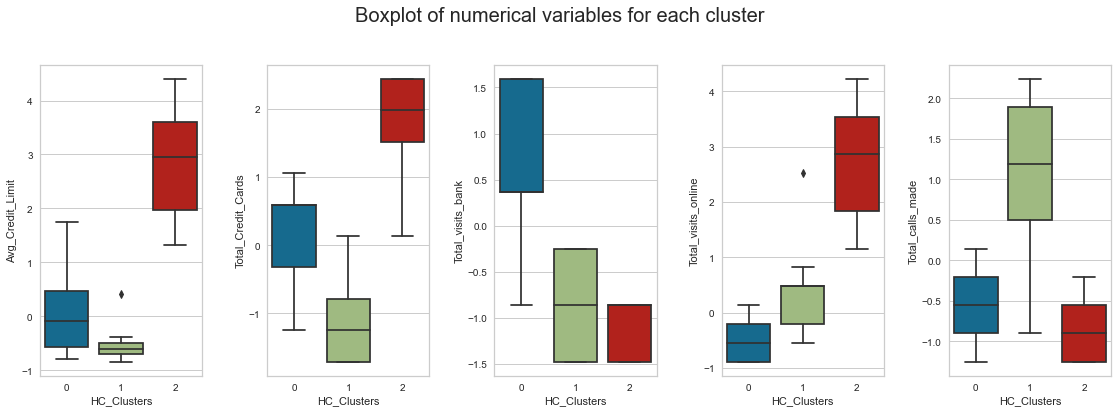

In [44]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for i in range(5):
    sns.boxplot(ax=axes[i],y=subset_scaled_df_for_HC[all_col[counter]],x=subset_scaled_df_for_HC['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

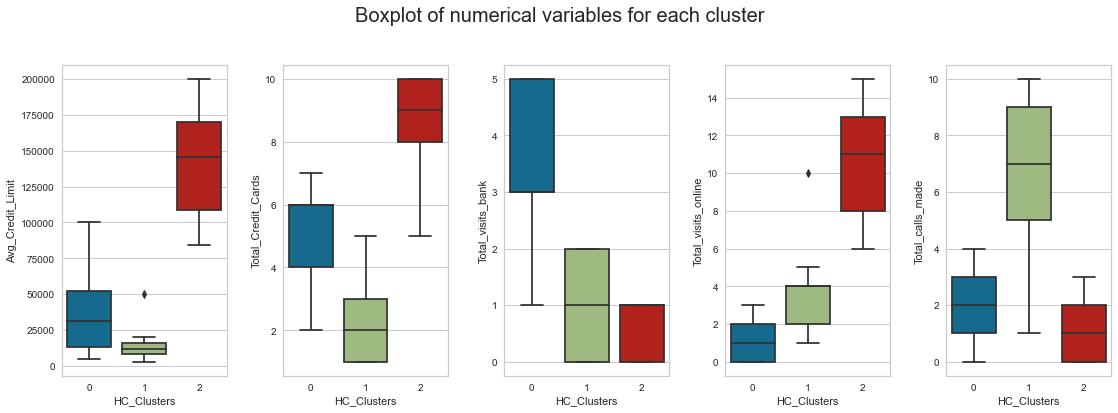

In [47]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for i in range(5):
    sns.boxplot(ax=axes[i],y=df_HC[all_col[counter]],x=subset_scaled_df_for_HC['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

**Observation**

1. Average credit limit for cluster0 customers is around 32000. Cluster1 customers have least averae credit limit.
2. Cluster 1 customers hold least amount of credit card with mean around 2.
3. Cluster 0 customer make most of the bank visits.
4. Cluster2 customers make most online visits.
5. Cluster1 customer makes most phone calls

### Perform cluster profiling  and comparing two clusters  

**Cluster profiling for K-Means cluster**

In [48]:
cluster_profile = df_KMeans.groupby('K_means_clusters').mean()

In [49]:
cluster_profile['count_in_each_segments'] = df_KMeans.groupby('K_means_clusters')['Total_Credit_Cards'].count().values

In [50]:
# lets display cluster profile
cluster_profile.style.highlight_max(color = 'lightblue', axis = 0)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_clusters,,,,,,,,
0,417.528497,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,117.857143,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,611.280000,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50


**Cluster profiling for Hierarchical cluster**

In [51]:
df_HC['HC_Clusters'] = HCmodel.labels_
cluster_profile = df_HC.groupby('HC_Clusters').mean()
cluster_profile['count_in_each_segments'] = df_HC.groupby('HC_Clusters')['Total_Credit_Cards'].count().values

In [52]:
# lets display cluster profile
cluster_profile.style.highlight_max(color = 'lightblue', axis = 0)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,,,
0,417.862338,54895.745455,33851.948052,5.516883,3.493506,0.979221,1.994805,385
1,118.617778,55213.568889,12151.111111,2.422222,0.937778,3.546667,6.857778,225
2,611.280000,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50


**Observation**

After developing two different clustering methods K-Means and Hierarchical method, we see that both clustering has created almost identical clusters with only diference of one data point put into different cluster. This indicates that we can explain the customers behaviors accurately to the Bank for them to form a new Marketing Strategy to attract the current customers by offering better services.


### Actionable Insights & Recommendations:

Lets look into different clusters and try to find out the specific behavior of the customers of the group:


    Cluster 0: This cluster contains most noumner of bank customers (385). The mean value of  Average Credit Limit for this group is 33800 and customer in this cluster hold from 5 to 6 credit cards. Customers in this cluster visits the bank more often compared to other two groups. 

    Cluster 1: In this cluster belong the 1/3 of customers, that is 225 customers. The mean value of Average Credit Limit is least among the group around 12000, hold up to 2-3 credit cards and they prefer telephone to communicate with the Bank. So these are the new potential customers to buy new products or upgrade their status.

    Cluster 2: In this cluster belong few (50) probably the very wealthy customers of the Bank with high Average Credit card Limit with mean around 140000, holding 8-9 cards. These  customers rarely visit the bank but they extensively use the web Banking services. 
    

Bank should focus on customers on cluster 1 cuase they have vely less credit card and less credit limit. They also try to do most of their business with telephonic communication. Bank could target these customers for any new marketing strategy by offering better service. Bank can also encourage these group to visit online more frequently.
Bank could also encourage cluster 0 customers to visit online more frequently as these are the customer who prefer physical visit to bank and are least intersted in online services.